# Biquad Alignment

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.signal import lfilter
from scipy import signal
import scipy
import math
from iir_biquad import iir_biquad as iir_biquad_patrick
from iir_biquad import test as test_patrick
from IIRSim import *
from IIRSimUtils import *
from FrequencyResponse import *
from FPGATestIO import *
from scipy.special import eval_chebyu

## Alignment Pulse and Coefficients

In [2]:
# Parameters for the filter configuation
TRIALS = 1
NOTCH = 650
Q_FACTOR = 8
ADVANCE=0
USING_NOTCH=False

# Used for aligning final verilog output with input. Not yet aligned (144 prior to incremental)
verilog_nominal_latency = (15+18)*8
b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

# Retrieve and fill Verilog data
verilog_data = []
data = []
# with open("003_files/outputs/verilog/timing_pulse_b_121_a1_0_a2_0_advance_%d.dat"%ADVANCE, "r") as in_file:
with open("003_files/outputs/verilog/timing_pulse_advance_%d_IIR.dat"%ADVANCE, "r") as in_file:
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
# Cut off the leading outputs, as they will not reflect any real data until the clock reaches latency
verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)

# Retrieve the input data
pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
pulse_run = pulse_run[ADVANCE:]
pulse_original_samps = pulse_run.copy()

# Cut off the trailing inputs, as they will not be reflected in recorded output due to the latency
pulse_samps = pulse_run[:-verilog_nominal_latency].copy()

# Debug information to make sure intput/output are the same length
if(len(verilog_data) != len(pulse_run)):
    print("Warning: input and output data lengths are different!")
    print("Output Data Length: %s\nInput data Length:  %s"%(len(verilog_data), len(pulse_run)))

if(USING_NOTCH):
    # Retrieve the coefficients used to configure the notch filter
    coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

Output Data Length: 79792
Input data Length:  80064


In [3]:
if(USING_NOTCH):
    # Generate python-only output
    python_data_IIR = iir_biquad_run_fixed_point(pulse_samps.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 
    python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
    
    python_data_FIR = np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],pulse_samps.copy())),dtype=np.int64)
    python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) ,14)
    
    python_IIR_trimmed = python_data_IIR[:-verilog_nominal_latency].copy()
    python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
    python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()
    
    lfilter_data_IIR = lfilter([1,0,0],a, pulse_samps.copy()) 
    lfilter_data_IIR_trimmed = lfilter_data_IIR.copy()
    lfilter_data = lfilter(b,a, pulse_samps.copy()) 
    lfilter_data_trimmed = lfilter_data.copy()

In [4]:
# Make lengths divisible by 8s
clipped_length = int(len(verilog_data)/8)*8
incremental_data = verilog_data.copy()[:clipped_length]
pulse_run = pulse_run[:clipped_length]

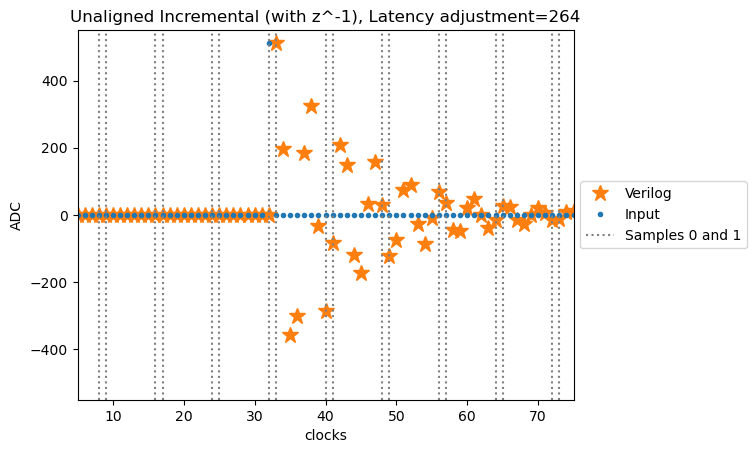

In [5]:
# clocks = range(len(pulse_samps))
clocks = range(np.min([len(pulse_samps),len(incremental_data)]))
# print("Clipped Length: %s"%(clipped_length))
# print("Incremental Data Length: %s"%(len(incremental_data)))
# print("Pulse Run Length: %s"%(len(pulse_run)))
# print("Clocks Length: %s"%(len(clocks)))
plt.plot(clocks, incremental_data, linestyle="None", marker="*", markersize=12, label="Verilog", color="C1")
# plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfilter BQ", alpha=0.8, color="C2")
# plt.plot(clocks, IIR_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR", color="C1")
plt.plot(clocks, pulse_samps[:len(clocks)], linestyle="None", marker=".", label="Input", color="C0")
for i in range(40):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")

plt.axvline(x=8*41, linestyle=":", color="grey", label="Samples 0 and 1")
plt.xlim(0,200)
plt.xlim(5,75)
# plt.xlim(140,170)
plt.ylim(-550,550)
# plt.xlim(100,150)
# plt.ylim(-5,5)
# plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.title("Unaligned Incremental (with z^-1), Latency adjustment=%s"%verilog_nominal_latency)
plt.xlabel("clocks")
plt.ylabel("ADC")# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("003_files/IIR_Impulse.png",dpi=500, bbox_inches='tight')
plt.show()
# print(b_fixed_point_signed/(2**14))
# print(a_fixed_point_signed/(2**14))


## Alignment With Biquad

b: [ 0.9214121 -0.3831447  0.9214121]
a: [ 1.        -0.3831447  0.8428242]
Output Data Length: 79904
Input data Length:  80048


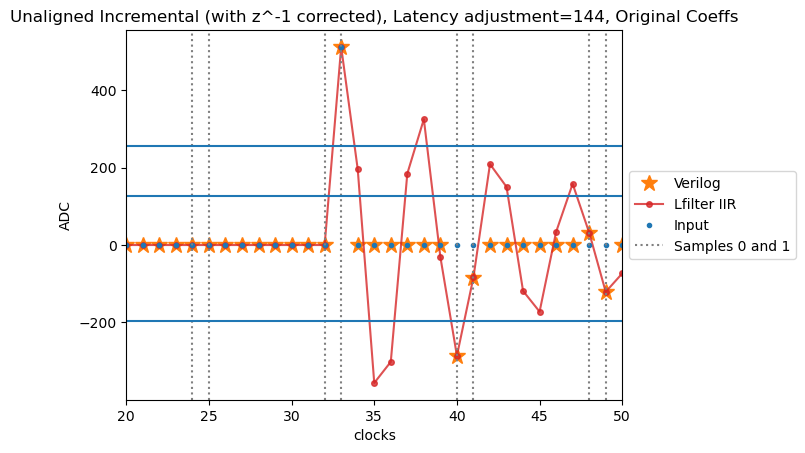

Output Data Length: 79904
Input data Length:  80048


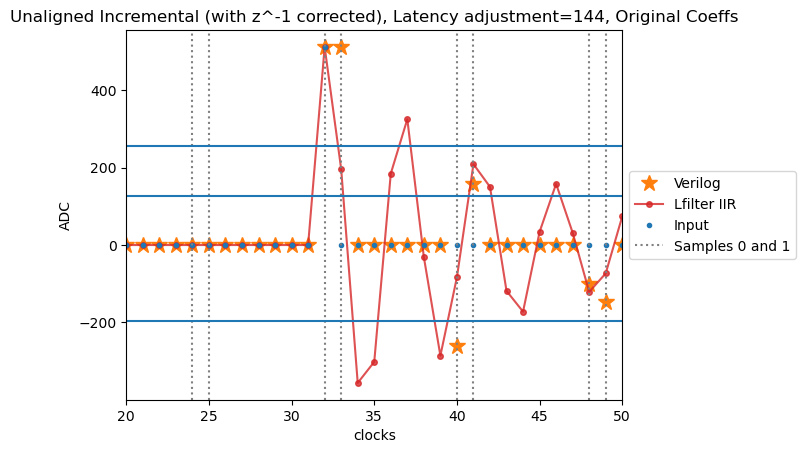

Output Data Length: 79904
Input data Length:  80048


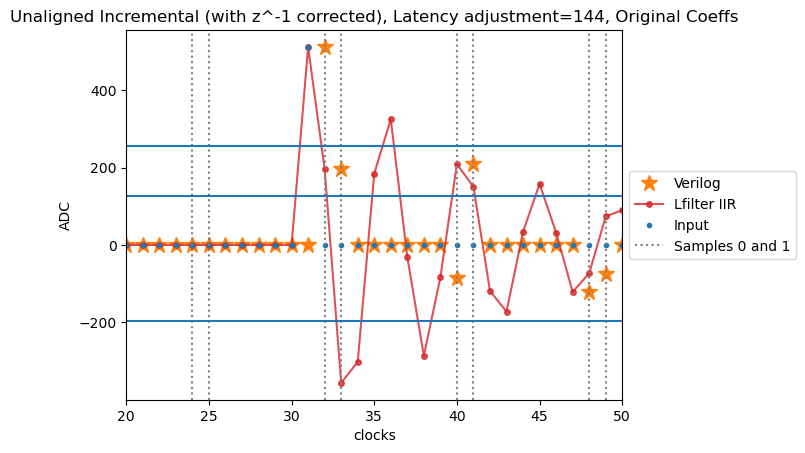

Output Data Length: 79904
Input data Length:  80048


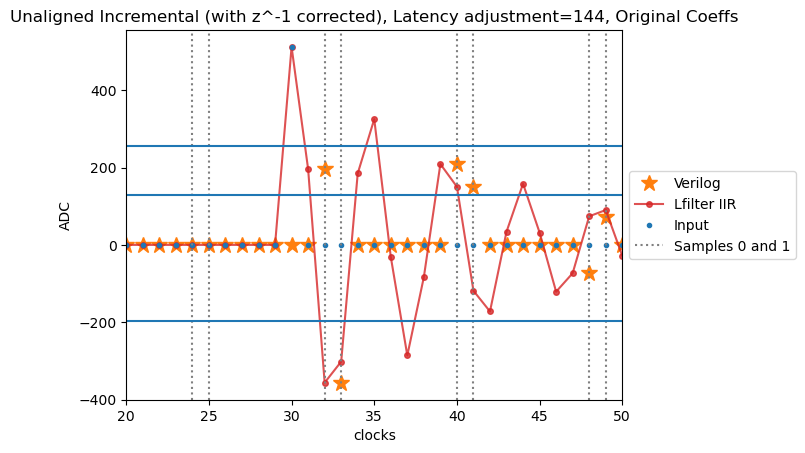

Output Data Length: 79904
Input data Length:  80048


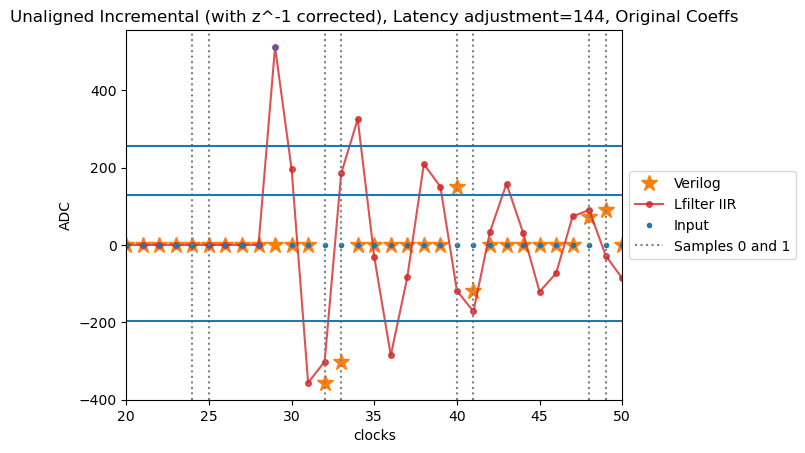

Output Data Length: 79904
Input data Length:  80048


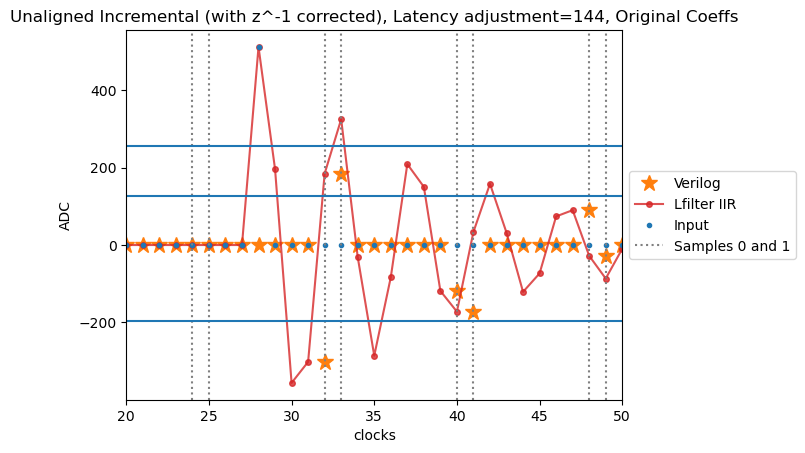

Output Data Length: 79904
Input data Length:  80048


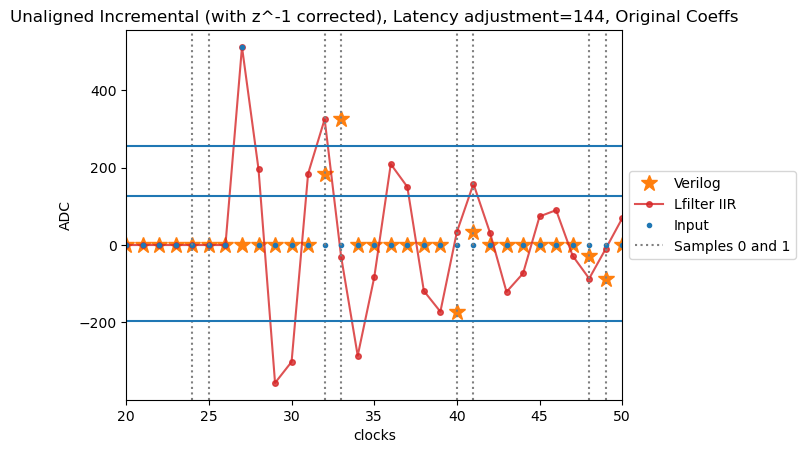

Output Data Length: 79904
Input data Length:  80048


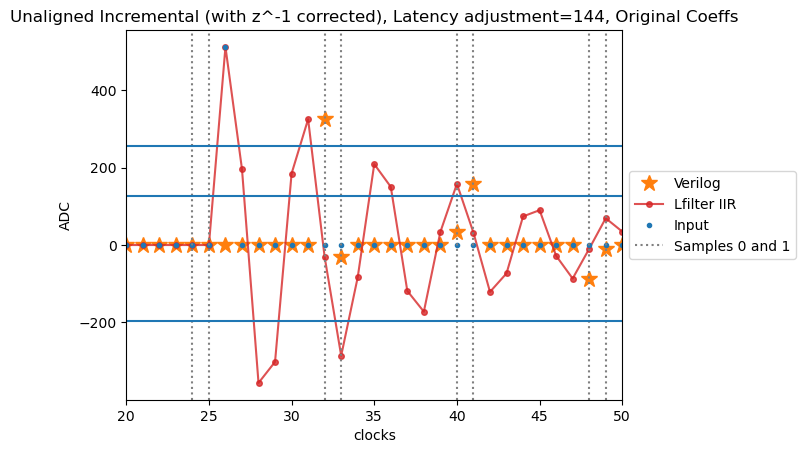

Output Data Length: 79904
Input data Length:  80048


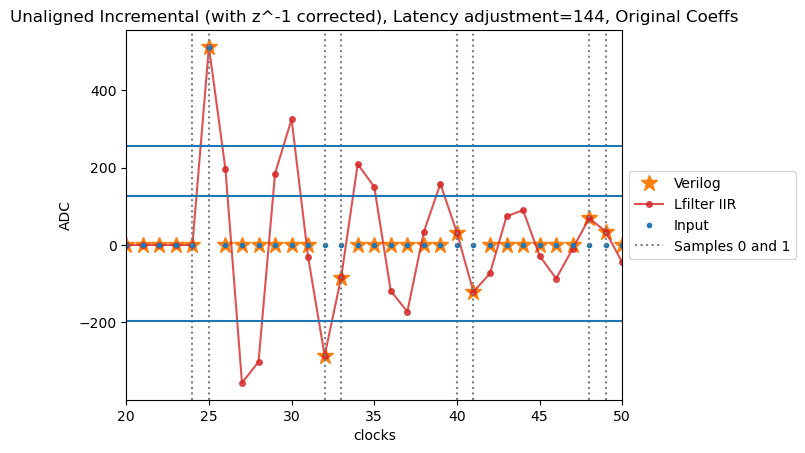

Output Data Length: 79904
Input data Length:  80048


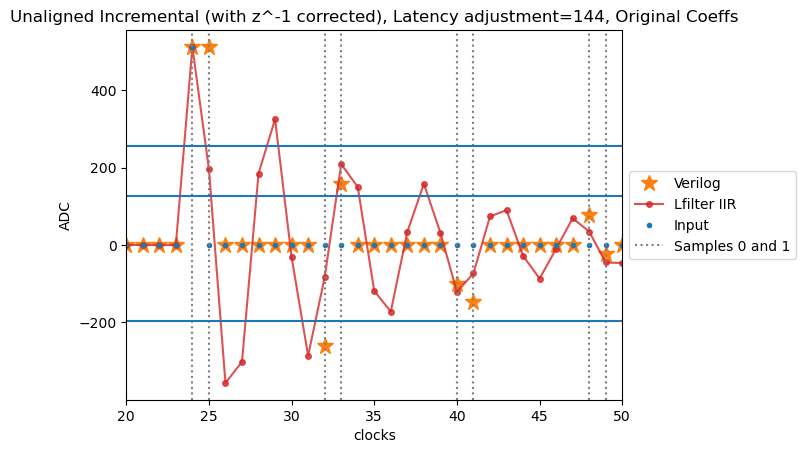

In [24]:
# Parameters for the filter configuation
TRIALS = 1
NOTCH = 650
Q_FACTOR = 8
USING_NOTCH=True
# ADVANCE=1

# Used for aligning final verilog output with input. Not yet aligned (144 prior to incremental)
# verilog_nominal_latency = (15+18)*8
processing_phase = 3
verilog_nominal_latency = (18)*8# + processing_phase # The +1 is a phase WITHIN the FPGA clock, must come from processing 

pulse_zero_section_latency = 1 # Only use when the zero section is being ignored (b=1, a=0)

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

print("b: %s"%b)
print("a: %s"%a)

for ADVANCE in range(10):

    # Retrieve and fill Verilog data
    verilog_data = []
    data = []
    # with open("003_files/outputs/verilog/pulse_output_height_512_incremental_notch_%sMHz_%sQ.dat"%(NOTCH, Q_FACTOR), "r") as in_file:
    with open("003_files/outputs/verilog/timing_pulse_advance_%d_IIR_no_inc.dat"%ADVANCE, "r") as in_file:
    # with open("003_files/outputs/verilog/timing_pulse_advance_%d_IIR_no_inc_alternate.dat"%ADVANCE, "r") as in_file:
        for line in in_file:
            data.append(convert_from_fixed_point(int(int(line)), 12, 0))
    # Cut off the leading outputs, as they will not reflect any real data until the clock reaches latency
    verilog_data = np.array(data[verilog_nominal_latency:-1*(8-(verilog_nominal_latency%8))],dtype=np.int64)
    
    # Retrieve the input data
    pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
    pulse_run = np.concatenate((np.zeros(pulse_zero_section_latency),pulse_run[ADVANCE:-1*(16-ADVANCE+pulse_zero_section_latency)]))
    pulse_original_samps = pulse_run.copy()
    
    # Cut off the trailing inputs, as they will not be reflected in recorded output due to the latency
    pulse_samps = pulse_run[:-1*(verilog_nominal_latency + (8-(verilog_nominal_latency%8)))].copy()
    
    # Debug information to make sure intput/output are the same length
    if(len(verilog_data) != len(pulse_run)):
        print("Warning: input and output data lengths are different!")
        print("Output Data Length: %s\nInput data Length:  %s"%(len(verilog_data), len(pulse_run)))
    
    if(USING_NOTCH):
        # Retrieve the coefficients used to configure the notch filter
        # coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s_alternate.dat"%(NOTCH,Q_FACTOR))
        coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))
    
    if(USING_NOTCH):
        # Generate python-only output
        python_data_IIR = iir_biquad_run_fixed_point(pulse_samps.copy(), coeffs_fixed_point_signed, 
                                                 decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 
        python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
        
        python_data_FIR = np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],pulse_samps.copy())),dtype=np.int64)
        python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                                 decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) ,14)
        
        python_IIR_trimmed = python_data_IIR[:-1*(verilog_nominal_latency + (8-(verilog_nominal_latency%8)))].copy()
        python_data_trimmed = python_data[:-1*(verilog_nominal_latency + (8-(verilog_nominal_latency%8)))].copy()
        python_data_zero_first_trimmed = python_data_zero_first[:-1*(verilog_nominal_latency + (8-(verilog_nominal_latency%8)))].copy()
        
        lfilter_data_IIR = lfilter([1,0,0],a, pulse_samps.copy()) 
        # lfilter_data_IIR_trimmed = lfilter_data_IIR.copy()
        lfilter_data = lfilter(b,a, pulse_samps.copy()) 
        lfilter_data_trimmed = lfilter_data.copy()
    
    # Make lengths divisible by 8s
    clipped_length = int(np.min([len(pulse_samps),len(verilog_data)])/8)*8
    incremental_data = verilog_data.copy()[:clipped_length]
    lfilter_data_IIR_trimmed = lfilter_data_IIR.copy()[:clipped_length]
    python_data_trimmed = python_data.copy()[:clipped_length]
    pulse_run = pulse_run[:clipped_length]
    
    # clocks = range(len(pulse_samps))
    clocks = range(np.min([len(pulse_samps),len(incremental_data)]))
    # print("Clipped Length: %s"%(clipped_length))
    # print("Incremental Data Length: %s"%(len(incremental_data)))
    # print("Pulse Run Length: %s"%(len(pulse_run)))
    # print("Clocks Length: %s"%(len(clocks)))
    plt.plot(clocks, incremental_data, linestyle="None", marker="*", markersize=12, label="Verilog", color="C1")
    # plt.plot(clocks, python_data, linestyle="-", marker="x", markersize=12, label="PythonSim", color="C1")
    # plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfilter BQ", alpha=0.8, color="C2")
    plt.plot(clocks, lfilter_data_IIR_trimmed[:len(clocks)], marker="o", markersize=4, linestyle="-", label="Lfilter IIR", alpha=0.8, color="C3")
    plt.plot(clocks, pulse_original_samps[:len(clocks)], linestyle="None", marker=".", label="Input", color="C0")
    for i in range(40):
        plt.axvline(x=8*i, linestyle=":", color="grey")
        plt.axvline(x=8*i+1, linestyle=":", color="grey")
    
    plt.axvline(x=8*41, linestyle=":", color="grey", label="Samples 0 and 1")
    plt.xlim(0,200)
    plt.xlim(15,100)
    plt.xlim(20,50)
    
    # plt.xlim(0,20)
    # plt.xlim(140,170)
    # plt.ylim(-550,550)
    plt.axhline(y=512/2)
    plt.axhline(y=512/4)
    plt.axhline(y=-196)
    # plt.xlim(100,150)
    # plt.ylim(-5,5)
    # plt.legend()
    # plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
    # plt.title("Unaligned Incremental (with z^-1 corrected), Latency adjustment=%s, Alternate Coeffs"%verilog_nominal_latency)
    plt.title("Unaligned Incremental (with z^-1 corrected), Latency adjustment=%s, Original Coeffs"%verilog_nominal_latency)
    plt.xlabel("clocks")
    plt.ylabel("ADC")# Put a legend to the right of the current axis
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("003_files/IIR_Impulse_Advance_%d_original.png"%ADVANCE,dpi=500, bbox_inches='tight')
    plt.show()
    # print(b_fixed_point_signed/(2**14))
    # print(a_fixed_point_signed/(2**14))


## Alignment With Pole FIR

b: [ 0.9214121 -0.3831447  0.9214121]
a: [ 1.        -0.3831447  0.8428242]
Output Data Length: 79904
Input data Length:  80048


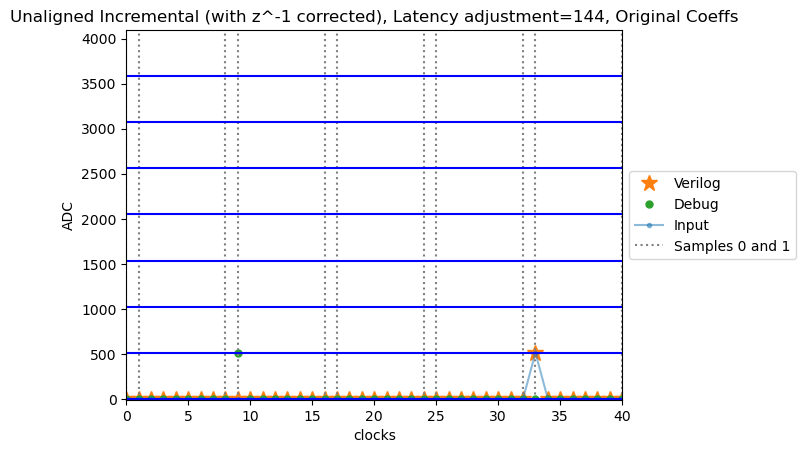

Output Data Length: 79904
Input data Length:  80048


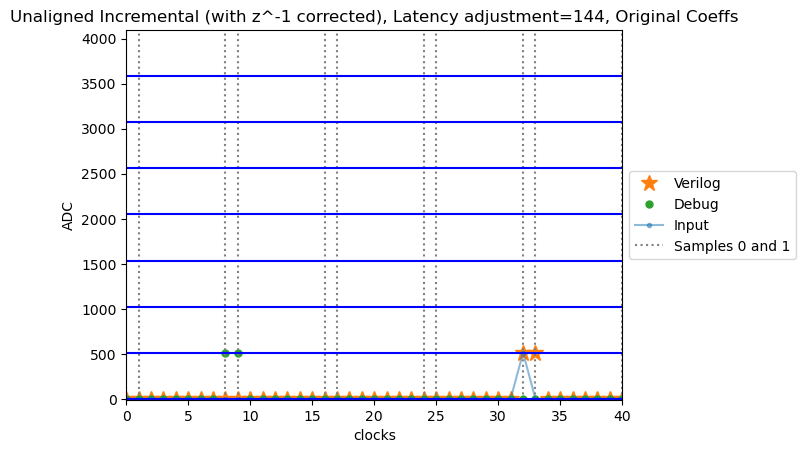

Output Data Length: 79904
Input data Length:  80048


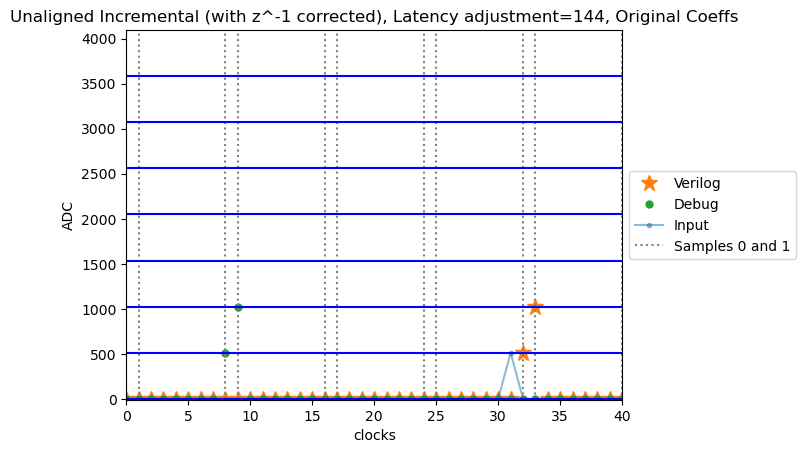

Output Data Length: 79904
Input data Length:  80048


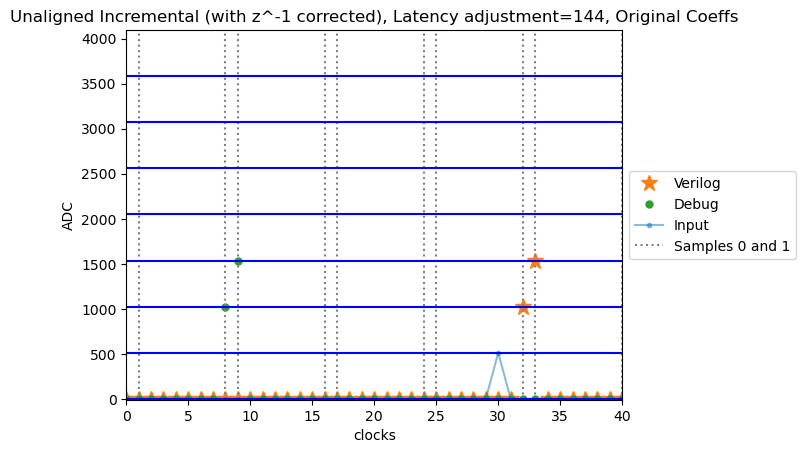

Output Data Length: 79904
Input data Length:  80048


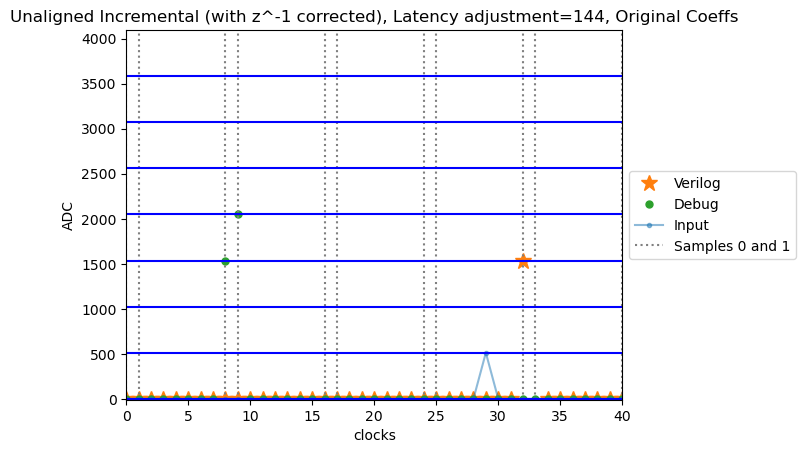

Output Data Length: 79904
Input data Length:  80048


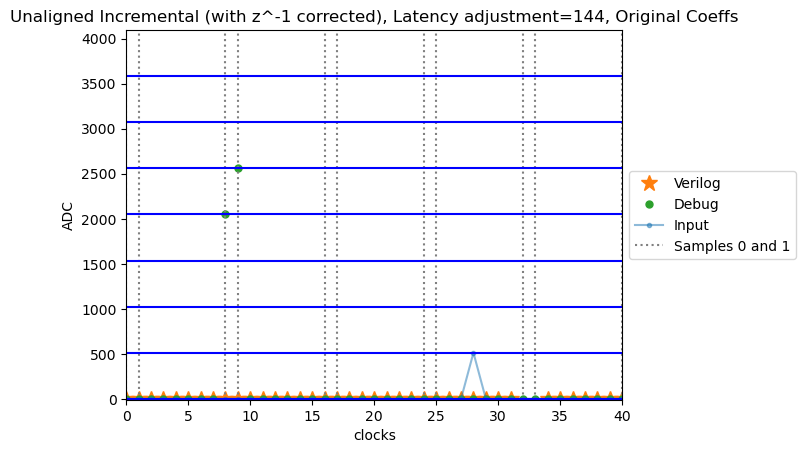

Output Data Length: 79904
Input data Length:  80048


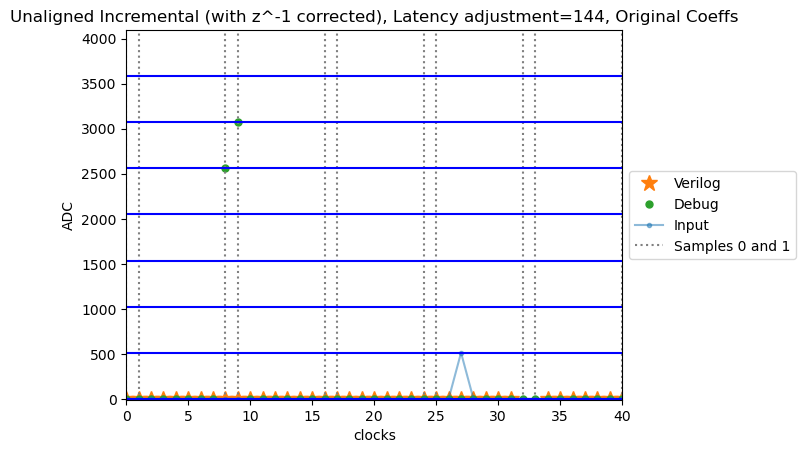

Output Data Length: 79904
Input data Length:  80048


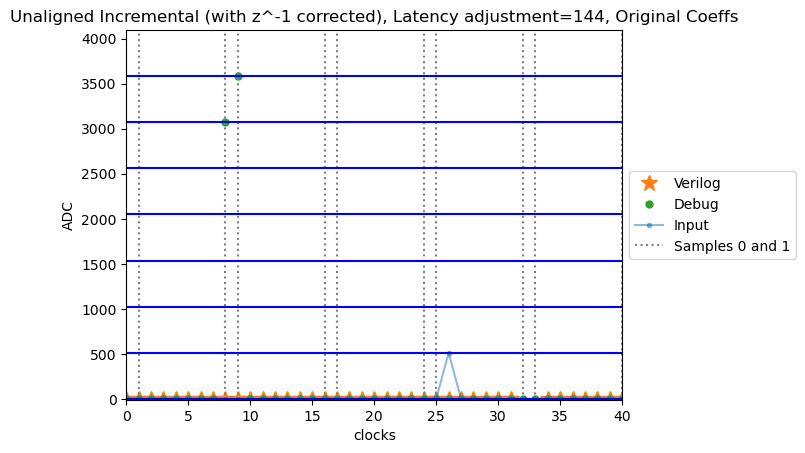

Output Data Length: 79904
Input data Length:  80048


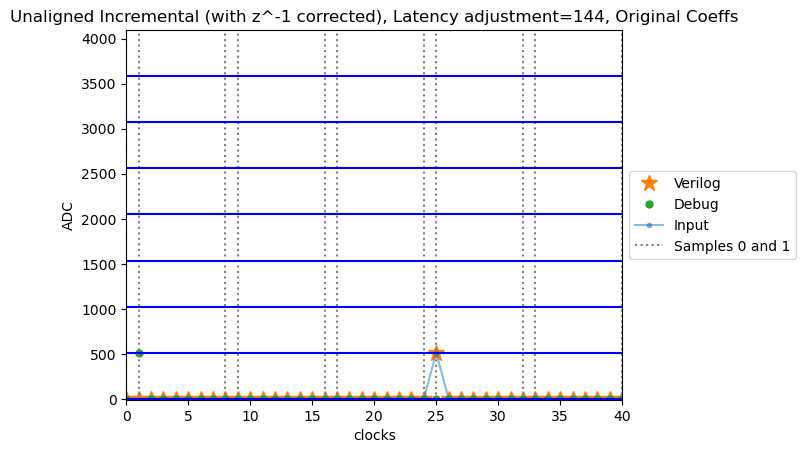

Output Data Length: 79904
Input data Length:  80048


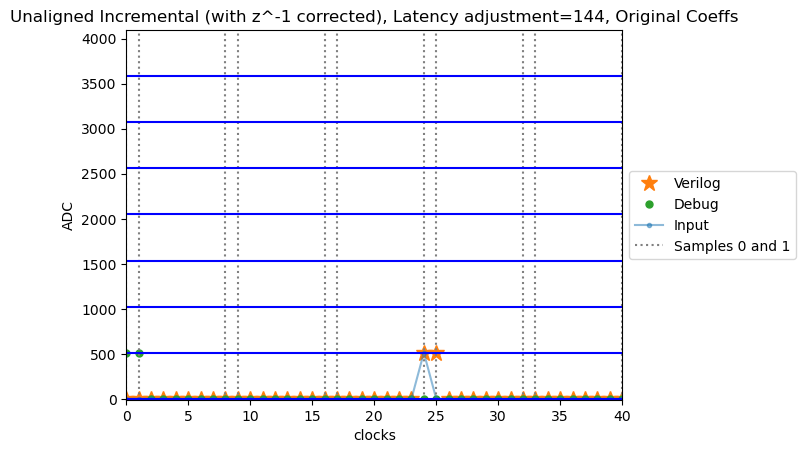

In [74]:
# Parameters for the filter configuation
TRIALS = 1
NOTCH = 650
Q_FACTOR = 8
USING_NOTCH=False
# ADVANCE=1

# Used for aligning final verilog output with input. Not yet aligned (144 prior to incremental)
# verilog_nominal_latency = (15+18)*8
processing_phase = 3
verilog_nominal_latency = (18)*8# + processing_phase # The +1 is a phase WITHIN the FPGA clock, must come from processing 

pulse_zero_section_latency = 1 # Only use when the zero section is being ignored (b=1, a=0)

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

print("b: %s"%b)
print("a: %s"%a)

for ADVANCE in range(10):

    # Retrieve and fill Verilog data
    verilog_data = []
    data = []
    # with open("003_files/outputs/verilog/pulse_output_height_512_incremental_notch_%sMHz_%sQ.dat"%(NOTCH, Q_FACTOR), "r") as in_file:
    with open("003_files/outputs/verilog/timing_pulse_advance_FIR_static_%d_IIR.dat"%ADVANCE, "r") as in_file:
    # with open("003_files/outputs/verilog/timing_pulse_advance_%d_IIR_no_inc_alternate.dat"%ADVANCE, "r") as in_file:
        for line in in_file:
            data.append(convert_from_fixed_point(int(int(line)), 12, 0))
    # Cut off the leading outputs, as they will not reflect any real data until the clock reaches latency
    verilog_data = np.array(data[verilog_nominal_latency:-1*(8-(verilog_nominal_latency%8))],dtype=np.int64)

    # Retrieve and fill Verilog data
    debug_data = []
    data = []
    shift=0
    # with open("003_files/outputs/verilog/pulse_output_height_512_incremental_notch_%sMHz_%sQ.dat"%(NOTCH, Q_FACTOR), "r") as in_file:
    with open("003_files/outputs/verilog/timing_BQ_expanded_advanceFIR_static_%d_IIR.dat"%ADVANCE, "r") as in_file:
    # with open("003_files/outputs/verilog/timing_pulse_advance_%d_IIR_no_inc_alternate.dat"%ADVANCE, "r") as in_file:
        for line in in_file:
            data.append(convert_from_fixed_point(int(int(line)), 21+shift, 27-shift))
    # Cut off the leading outputs, as they will not reflect any real data until the clock reaches latency
    debug_data = np.array(data[verilog_nominal_latency:-1*(8-(verilog_nominal_latency%8))],dtype=np.int64)
    
    # Retrieve the input data
    pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
    pulse_run = np.concatenate((np.zeros(pulse_zero_section_latency),pulse_run[ADVANCE:-1*(16-ADVANCE+pulse_zero_section_latency)]))
    pulse_original_samps = pulse_run.copy()
    
    # Cut off the trailing inputs, as they will not be reflected in recorded output due to the latency
    pulse_samps = pulse_run[:-1*(verilog_nominal_latency + (8-(verilog_nominal_latency%8)))].copy()
    
    # Debug information to make sure intput/output are the same length
    if(len(verilog_data) != len(pulse_run)):
        print("Warning: input and output data lengths are different!")
        print("Output Data Length: %s\nInput data Length:  %s"%(len(verilog_data), len(pulse_run)))
    
    # if(USING_NOTCH):
    #     # Retrieve the coefficients used to configure the notch filter
    #     # coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s_alternate.dat"%(NOTCH,Q_FACTOR))
    #     coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))
    
    # if(USING_NOTCH):
    #     # Generate python-only output
    #     python_data_IIR = iir_biquad_run_fixed_point(pulse_samps.copy(), coeffs_fixed_point_signed, 
    #                                              decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 
    #     python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
        
    #     python_data_FIR = np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],pulse_samps.copy())),dtype=np.int64)
    #     python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
    #                                              decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) ,14)
        
    #     python_IIR_trimmed = python_data_IIR[:-1*(verilog_nominal_latency + (8-(verilog_nominal_latency%8)))].copy()
    #     python_data_trimmed = python_data[:-1*(verilog_nominal_latency + (8-(verilog_nominal_latency%8)))].copy()
    #     python_data_zero_first_trimmed = python_data_zero_first[:-1*(verilog_nominal_latency + (8-(verilog_nominal_latency%8)))].copy()
        
    #     lfilter_data_IIR = lfilter([1,0,0],a, pulse_samps.copy()) 
    #     # lfilter_data_IIR_trimmed = lfilter_data_IIR.copy()
    #     lfilter_data = lfilter(b,a, pulse_samps.copy()) 
    #     lfilter_data_trimmed = lfilter_data.copy()
    
    # Make lengths divisible by 8s
    clipped_length = int(np.min([len(pulse_samps),len(verilog_data)])/8)*8
    verilog_data_plot = verilog_data.copy()[:clipped_length]
    debug_data_plot = debug_data.copy()[:clipped_length]
    lfilter_data_IIR_trimmed = lfilter_data_IIR.copy()[:clipped_length]
    python_data_trimmed = python_data.copy()[:clipped_length]
    pulse_run = pulse_run[:clipped_length]
    
    # clocks = range(len(pulse_samps))
    clocks = range(np.min([len(pulse_samps),len(incremental_data)]))
    # print("Clipped Length: %s"%(clipped_length))
    # print("Incremental Data Length: %s"%(len(incremental_data)))
    # print("Pulse Run Length: %s"%(len(pulse_run)))
    # print("Clocks Length: %s"%(len(clocks)))
    plt.plot(clocks, verilog_data_plot, linestyle="None", marker="*", markersize=12, label="Verilog", color="C1")
    plt.plot(clocks, debug_data_plot, linestyle="None", marker="o", markersize=5, label="Debug", color="C2")
    # plt.plot(clocks, python_data, linestyle="-", marker="x", markersize=12, label="PythonSim", color="C1")
    # plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfilter BQ", alpha=0.8, color="C2")
    # plt.plot(clocks, lfilter_data_IIR_trimmed[:len(clocks)], marker="o", markersize=4, linestyle="-", label="Lfilter IIR", alpha=0.8, color="C3")
    # plt.plot(clocks, pulse_original_samps[:len(clocks)], linestyle="None", marker=".", label="Input", color="C0")
    plt.plot(clocks, pulse_original_samps[:len(clocks)], linestyle="-", marker=".", label="Input", color="C0", alpha=0.5)
    for i in range(40):
        plt.axvline(x=8*i, linestyle=":", color="grey")
        plt.axvline(x=8*i+1, linestyle=":", color="grey")

    for i in range(8):
        plt.axhline(y=512*i, linestyle="-", color="blue")
        # plt.axhline(y=512*i+1, linestyle="-", color="blue")
    
    plt.axvline(x=8*41, linestyle=":", color="grey", label="Samples 0 and 1")
    plt.xlim(0,200)
    plt.xlim(15,100)
    plt.xlim(0,40)
    
    # plt.xlim(0,20)
    # plt.xlim(140,170)
    # plt.ylim(-550,550)
    plt.ylim(-10,512*8)
    # plt.ylim(-2,3000)
    # plt.legend()
    # plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
    # plt.title("Unaligned Incremental (with z^-1 corrected), Latency adjustment=%s, Alternate Coeffs"%verilog_nominal_latency)
    plt.title("Unaligned Incremental (with z^-1 corrected), Latency adjustment=%s, Original Coeffs"%verilog_nominal_latency)
    plt.xlabel("clocks")
    plt.ylabel("ADC")# Put a legend to the right of the current axis
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("003_files/IIR_Impulse_Advance_%d_FIR_Debug.png"%ADVANCE,dpi=500, bbox_inches='tight')
    plt.show()
    # print(b_fixed_point_signed/(2**14))
    # print(a_fixed_point_signed/(2**14))


In [67]:
b, a = signal.iirnotch(300,0.7, 3000)

In [14]:
b*16384

array([15096.41583909, -6277.44268479, 15096.41583909])

In [15]:
NOTCH = 650
Q_FACTOR = 8
b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)
for i in range(len(b)):
    b_fixed_point_signed[i] = np.floor(b[i] * (2**14))
b_fixed_point_signed = np.array(b_fixed_point_signed, dtype=np.int64)
for i in range(len(a)):
    a_fixed_point_signed[i] = np.floor(a[i] * (2**14))
a_fixed_point_signed = np.array(a_fixed_point_signed, dtype=np.int64)

In [10]:
print(a_fixed_point_signed)

[16384 -6278 13808]


In [11]:
print(a)

[ 1.        -0.3831447  0.8428242]
